 # Análisis de Preferencias y Factores Externos en Viajes Compartidos: El Caso de Zuber en Chicago
 

En el vertiginoso mundo de los viajes compartidos, la capacidad de comprender y prever las preferencias de los usuarios es fundamental para el éxito de cualquier empresa en el mercado. En este contexto, nos sumergimos en el caso de Zuber, una nueva compañía de viajes compartidos que se prepara para ingresar al competitivo escenario de Chicago. Como analista encargado, nuestra misión es desentrañar los patrones subyacentes en la información disponible, desde las preferencias de los pasajeros hasta el impacto que los factores externos, como el clima, pueden tener en la frecuencia de los viajes. Para ello, nos sumergiremos en el análisis de datos de competidores y pondremos a prueba hipótesis cruciales que informarán las estrategias futuras de Zuber.

De los objetivos que se plantea alcansar son los siguientes:
* los 10 principales barrios.
* Realizar un analisis de las empresas de taxis y los número de viajes.
* los 10 barrios principales por número de finalizaciones.
* Realizar una hipótesis sobre la duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare No cambia los sábados lluviosos.

# Índice

1. [Importar los archivos](#importar-los-archivos)
2. [Estudio Del contenido de los datos](#estudiar-datos)
3. [Corrección de datos](#correcion-dato)
4. [Identificar los 10 principales barrios en términos de finalización del recorrido](#principales-barrios)
5. [Gráficos](#graficos)
6. [prueba de hipótesis ](#hipotesis)

# Paso 1. Carga de librerias, funciones y de datos a estudiar <a id='importar-los-archivos'></a>


In [1]:
#->librerias
# Importar librerias 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
from tabulate import tabulate
import re


In [2]:
#funciones
def convertir_titulos_minusculas(dataframe):
    """
    Convierte los títulos de las columnas de un DataFrame a minúsculas.

    Args:
    dataframe (pandas.DataFrame): El DataFrame al que se le cambiarán los nombres de las columnas.

    Returns:
    pandas.DataFrame: El DataFrame modificado con los títulos de las columnas en minúsculas.
    """
    # Copiar el DataFrame para evitar modificar el original
    df_modificado = dataframe.copy()

    # Convertir los nombres de las columnas a minúsculas
    df_modificado.columns = map(str.lower, df_modificado.columns)

    return df_modificado

def filtrar_dataframe_por_atipicos(df, columna, umbral=3):
    """
    Filtra los valores atípicos en una columna de un DataFrame de Pandas y devuelve el DataFrame filtrado.
    
    Args:
        df (DataFrame): El DataFrame de Pandas.
        columna (str): El nombre de la columna a filtrar.
        umbral (int): El umbral para determinar qué valores son atípicos.
    
    Returns:
        DataFrame: El DataFrame filtrado sin los valores atípicos.
    """
    # Calcular la media y la desviación estándar para la columna
    media = df[columna].mean()
    desviacion_estandar = df[columna].std()
    
    # Identificar los valores atípicos
    valores_atipicos = (df[columna] - media).abs() > umbral * desviacion_estandar
    
    # Filtrar el DataFrame
    df_filtrado = df[~valores_atipicos]
    
    return df_filtrado

def load_csv(path):
    try:
        tpm = pd.read_csv(path)
        print(f"Se cargo el archivo en la ruta: '{path}'")
        return  tpm
    except Exception as err:
        print("------------------")
        print(f"Unexpected {err=}, {type(err)=}")
        print("------------------")
        return NameError

def unique(df_tmp,column):
    valores_unicos = df_tmp[column].unique()
    for valor in valores_unicos:
        print(valor)
        
def info(df_tmp):
    print(list(df_tmp.columns))
    print()
    print(df_tmp.info())
    print()
    display(df_tmp.sample(5))
    print()

def mostrar_info_dataframe_tabla(dataframe):
    """
    Muestra la información del DataFrame en forma de tabla, incluyendo el tipo de datos de cada columna y la cantidad de valores no nulos.

    Args:
    dataframe (pandas.DataFrame): El DataFrame del que se mostrará la información.

    Returns:
    None
    """
    # Obtener información sobre el DataFrame
    info = []
    for col in dataframe.columns:
        tipo_dato = dataframe[col].dtype
        no_nulos = dataframe[col].count()
        valores_nulos = dataframe[col].isnull().sum()
        indice = 'Key' if 'id' in col.lower() and col.dtype == 'int'  else 'ok'
        info.append([col, no_nulos,valores_nulos, tipo_dato,indice])

    # Mostrar la tabla utilizando tabulate
    
    print(tabulate(info, headers=["Columna", "No-Nulos","nulos", "Tipo de datos","índice"], tablefmt="fancy_grid"))
    print(dataframe.describe())
    print()
    # Verificar si hay filas duplicadas en el DataFrame
    hay_duplicados = dataframe.duplicated().any()

    if hay_duplicados:
        print("El DataFrame tiene filas duplicadas.")
    else:
        print("El DataFrame no tiene filas duplicadas.")


def conservar_parte_cadena(columna):
    """
    Conserva la parte de la cadena que no cumpla con la expresión regular.

    Args:
    columna (pandas.Series): La columna del DataFrame que se va a analizar.

    Returns:
    pandas.Series: Una serie con las partes de las cadenas que no cumplen con los criterios.
    """
    # Expresión regular para detectar y extraer las partes de las cadenas
    patron = r'\b(?:\d{4}\s-\s\d{5}(?:\s-\s)?|(?:\d{4}\s-\s)?\d{5}(?:\s(?:-\s\d{5})?)?)\s*'
    # Función para extraer la parte de la cadena que no cumple con la expresión regular
    def extraer_parte(cadena):
        coincidencia = re.search(patron, cadena)
        if coincidencia:
            # Si se encuentra una coincidencia, se elimina esa parte de la cadena original
            return cadena.replace(coincidencia.group(), '')
        else:
            # Si no se encuentra ninguna coincidencia, se devuelve la cadena original
            return cadena

    # Aplicar la función a cada elemento de la columna
    partes_cadenas = columna.apply(extraer_parte)

    return partes_cadenas

def eliminar_espacio_inicial(columna):
    """
    Elimina el espacio inicial de los valores de una columna.

    Args:
    columna (pandas.Series): La columna del DataFrame que se va a procesar.

    Returns:
    pandas.Series: La columna con los espacios iniciales eliminados.
    """
    # Recorrer cada valor de la columna
    for i in range(len(columna)):
        # Verificar si el valor inicia con un espacio
        if columna[i][0] == ' ':
            # Eliminar el espacio inicial
            columna[i] = columna[i].lstrip()
    
    return columna

In [3]:
#->datos
# Leer el archivo y almacenarlo en df
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga múltiples archivos CSV con separadores específicos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenará los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'project_sql_result_01.csv': ',',    
    'project_sql_result_04.csv': ',',    
    'project_sql_result_07.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
df_companies = df_all.get('project_sql_result_01.csv') 
df_locations = df_all.get('project_sql_result_04.csv') 
df_viajes = df_all.get('project_sql_result_07.csv') 

Archivo cargado exitosamente desde 'datasets/project_sql_result_01.csv'
Archivo cargado exitosamente desde 'datasets/project_sql_result_04.csv'
Archivo cargado exitosamente desde 'datasets/project_sql_result_07.csv'


# Paso 2. Estudio Del contenido de los datos <a id='estudiar-datos'></a>


In [4]:
#info(df_companies)

mostrar_info_dataframe_tabla(df_companies)
df_companies.sample(5)

╒══════════════╤════════════╤═════════╤═════════════════╤══════════╕
│ Columna      │   No-Nulos │   nulos │ Tipo de datos   │ índice   │
╞══════════════╪════════════╪═════════╪═════════════════╪══════════╡
│ company_name │         64 │       0 │ object          │ ok       │
├──────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ trips_amount │         64 │       0 │ int64           │ ok       │
╘══════════════╧════════════╧═════════╧═════════════════╧══════════╛
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000

El DataFrame no tiene filas duplicadas.


,company_name,trips_amount
58,5062 - 34841 Sam Mestas,8
63,3556 - 36214 RC Andrews Cab,2
11,Globe Taxi,4383
24,Chicago Taxicab,1014
51,4623 - 27290 Jay Kim,15


In [5]:
unique(df_companies,'company_name')

Flash Cab
Taxi Affiliation Services
Medallion Leasin
Yellow Cab
Taxi Affiliation Service Yellow
Chicago Carriage Cab Corp
City Service
Sun Taxi
Star North Management LLC
Blue Ribbon Taxi Association Inc.
Choice Taxi Association
Globe Taxi
Dispatch Taxi Affiliation
Nova Taxi Affiliation Llc
Patriot Taxi Dba Peace Taxi Associat
Checker Taxi Affiliation
Blue Diamond
Chicago Medallion Management
24 Seven Taxi
Chicago Medallion Leasing INC
Checker Taxi
American United
Chicago Independents
KOAM Taxi Association
Chicago Taxicab
Top Cab Affiliation
Gold Coast Taxi
Service Taxi Association
5 Star Taxi
303 Taxi
Setare Inc
American United Taxi Affiliation
Leonard Cab Co
Metro Jet Taxi A
Norshore Cab
6742 - 83735 Tasha ride inc
3591 - 63480 Chuks Cab
1469 - 64126 Omar Jada
6743 - 78771 Luhak Corp
0118 - 42111 Godfrey S.Awir
6574 - Babylon Express Inc.
Chicago Star Taxicab
1085 - 72312 N and W Cab Co
2809 - 95474 C & D Cab Co Inc.
2092 - 61288 Sbeih company
3011 - 66308 JBL Cab Inc.
3620 - 52292 Da

In [6]:
mostrar_info_dataframe_tabla(df_locations)
df_locations.sample(5)

╒═══════════════════════╤════════════╤═════════╤═════════════════╤══════════╕
│ Columna               │   No-Nulos │   nulos │ Tipo de datos   │ índice   │
╞═══════════════════════╪════════════╪═════════╪═════════════════╪══════════╡
│ dropoff_location_name │         94 │       0 │ object          │ ok       │
├───────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ average_trips         │         94 │       0 │ float64         │ ok       │
╘═══════════════════════╧════════════╧═════════╧═════════════════╧══════════╛
       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667

El DataFrame no tiene filas duplicadas.


,dropoff_location_name,average_trips
76,Washington Heights,9.133333
62,Brighton Park,19.466667
7,Museum Campus,1510.000000
89,Mount Greenwood,3.137931
20,Rush & Division,395.533333


In [7]:
unique(df_locations,'dropoff_location_name')

Loop
River North
Streeterville
West Loop
O'Hare
Lake View
Grant Park
Museum Campus
Gold Coast
Sheffield & DePaul
Lincoln Park
East Village
Little Italy, UIC
Uptown
Near South Side
Garfield Ridge
Logan Square
Edgewater
West Town
Old Town
Rush & Division
North Center
Lincoln Square
Rogers Park
West Ridge
Irving Park
Hyde Park
Avondale
Wicker Park
Albany Park
United Center
Lower West Side
Douglas
Portage Park
Humboldt Park
Norwood Park
Kenwood
Bridgeport
Armour Square
Jefferson Park
Bucktown
North Park
Garfield Park
Mckinley Park
Belmont Cragin
Boystown
Chinatown
Grand Boulevard
Austin
Sauganash,Forest Glen
South Shore
Woodlawn
Little Village
Jackson Park
North Lawndale
Dunning
Ukrainian Village
Hermosa
Englewood
Chatham
New City
Grand Crossing
Brighton Park
Andersonville
Oakland
Ashburn
Washington Park
Auburn Gresham
Clearing
Roseland
Wrigleyville
Edison Park
South Chicago
Chicago Lawn
Beverly
Calumet Heights
Washington Heights
Archer Heights
Gage Park
Fuller Park
West Lawn
Morgan Park
S

### Conclusiones.

- Se observa para el 'df_companies', existen valores erróneos en la columna 'company_name'.

# Paso 3. Corrección de datos <a id='correcion-dato'></a>


In [8]:
#corregir los valores de 'df_companies' en la columna 'company_name'.

df_companies['company_name'] = conservar_parte_cadena(df_companies['company_name'])
df_companies['company_name'] = eliminar_espacio_inicial(df_companies['company_name'])

unique(df_companies,'company_name')


Flash Cab
Taxi Affiliation Services
Medallion Leasin
Yellow Cab
Taxi Affiliation Service Yellow
Chicago Carriage Cab Corp
City Service
Sun Taxi
Star North Management LLC
Blue Ribbon Taxi Association Inc.
Choice Taxi Association
Globe Taxi
Dispatch Taxi Affiliation
Nova Taxi Affiliation Llc
Patriot Taxi Dba Peace Taxi Associat
Checker Taxi Affiliation
Blue Diamond
Chicago Medallion Management
24 Seven Taxi
Chicago Medallion Leasing INC
Checker Taxi
American United
Chicago Independents
KOAM Taxi Association
Chicago Taxicab
Top Cab Affiliation
Gold Coast Taxi
Service Taxi Association
5 Star Taxi
303 Taxi
Setare Inc
American United Taxi Affiliation
Leonard Cab Co
Metro Jet Taxi A
Norshore Cab
Tasha ride inc
Chuks Cab
Omar Jada
Luhak Corp
Godfrey S.Awir
6574 - Babylon Express Inc.
Chicago Star Taxicab
N and W Cab Co
C & D Cab Co Inc.
Sbeih company
JBL Cab Inc.
David K. Cab Corp.
Tyrone Henderson
Arrington Enterprises
Ahzmi Inc
Lee Express Inc
Jay Kim
3721 - Santamaria Express, Alvaro Santam

In [9]:
mostrar_info_dataframe_tabla(df_viajes)
df_viajes.sample(5)


╒════════════════════╤════════════╤═════════╤═════════════════╤══════════╕
│ Columna            │   No-Nulos │   nulos │ Tipo de datos   │ índice   │
╞════════════════════╪════════════╪═════════╪═════════════════╪══════════╡
│ start_ts           │       1068 │       0 │ object          │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ weather_conditions │       1068 │       0 │ object          │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ duration_seconds   │       1068 │       0 │ float64         │ ok       │
╘════════════════════╧════════════╧═════════╧═════════════════╧══════════╛
       duration_seconds
count       1068.000000
mean        2071.731273
std          769.461125
min            0.000000
25%         1438.250000
50%         1980.000000
75%         2580.000000
max         7440.000000

El DataFrame tiene filas duplicadas.


,start_ts,weather_conditions,duration_seconds
273,2017-11-04 06:00:00,Good,2928.0
461,2017-11-11 12:00:00,Good,1968.0
982,2017-11-11 15:00:00,Good,2220.0
922,2017-11-18 08:00:00,Bad,1495.0
979,2017-11-04 07:00:00,Good,1140.0


_El DataFrame tiene filas duplicadas._

In [10]:
df_viajes = df_viajes.drop_duplicates()
mostrar_info_dataframe_tabla(df_viajes)

╒════════════════════╤════════════╤═════════╤═════════════════╤══════════╕
│ Columna            │   No-Nulos │   nulos │ Tipo de datos   │ índice   │
╞════════════════════╪════════════╪═════════╪═════════════════╪══════════╡
│ start_ts           │        871 │       0 │ object          │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ weather_conditions │        871 │       0 │ object          │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ duration_seconds   │        871 │       0 │ float64         │ ok       │
╘════════════════════╧════════════╧═════════╧═════════════════╧══════════╛
       duration_seconds
count        871.000000
mean        2096.308840
std          782.274717
min            0.000000
25%         1440.000000
50%         2015.000000
75%         2584.000000
max         7440.000000

El DataFrame no tiene filas duplicadas.


_La columna start_ts no es del tipo fecha._

In [11]:
df_viajes.info()
df_viajes['start_ts'] = dates = pd.to_datetime(df_viajes['start_ts'])
mostrar_info_dataframe_tabla(df_viajes)

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            871 non-null    object 
 1   weather_conditions  871 non-null    object 
 2   duration_seconds    871 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.2+ KB
╒════════════════════╤════════════╤═════════╤═════════════════╤══════════╕
│ Columna            │   No-Nulos │   nulos │ Tipo de datos   │ índice   │
╞════════════════════╪════════════╪═════════╪═════════════════╪══════════╡
│ start_ts           │        871 │       0 │ datetime64[ns]  │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ weather_conditions │        871 │       0 │ object          │ ok       │
├────────────────────┼────────────┼─────────┼─────────────────┼──────────┤
│ duration_seconds   │        871 │       0 │ float64         │ ok       │
╘═

C:\Users\Administrador\AppData\Local\Temp\ipykernel_21916\212733858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viajes['start_ts'] = dates = pd.to_datetime(df_viajes['start_ts'])


# Paso 4. "los 10 principales barrios" <a id='principales-barrios'></a>


In [12]:

top_10 = df_locations.sort_values(by='average_trips', ascending=False)
display(top_10.head(10))

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


# Paso 5. Corrección de datos <a id='graficos'></a>


### Empresas de taxis y número de viajes 

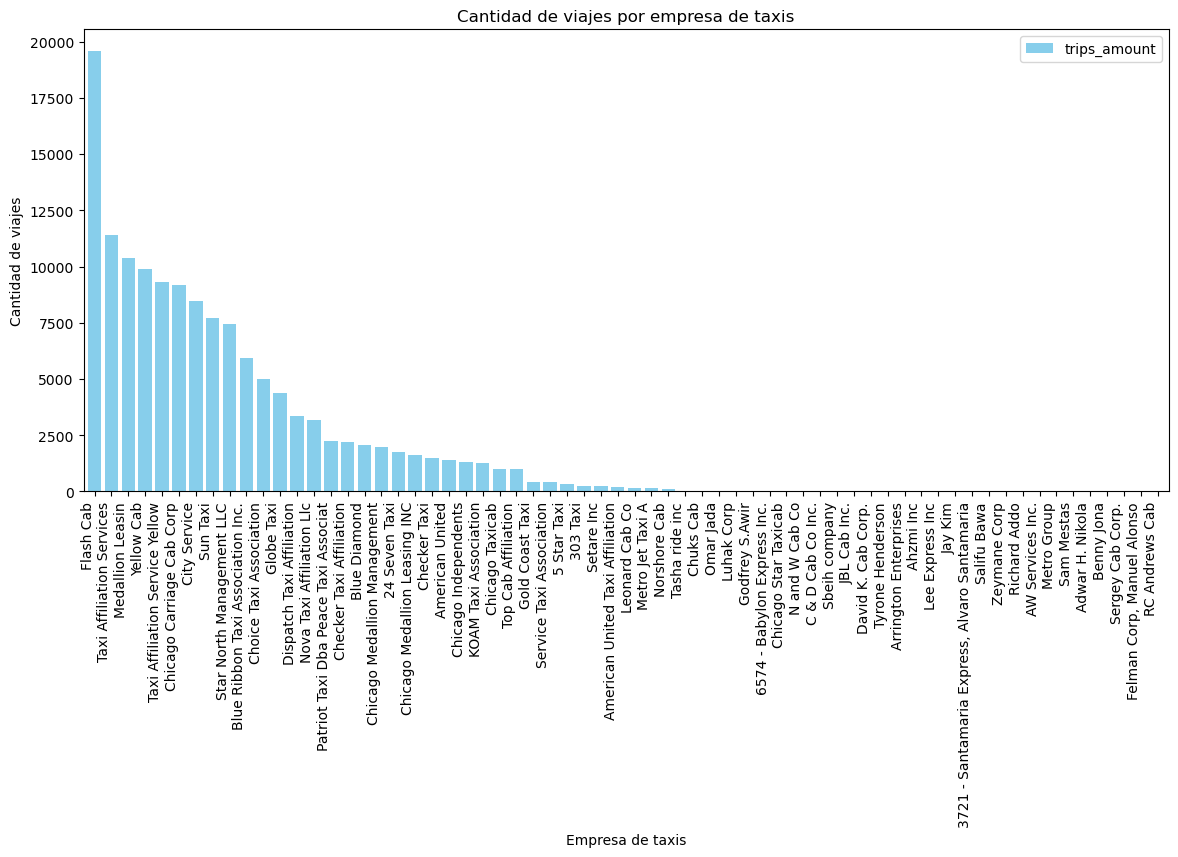

In [13]:

# Crear un gráfico de barras
ax = df_companies.plot(kind='bar', x='company_name', y='trips_amount', color='skyblue', figsize=(14, 6), width=0.8)

# Configurar el título y los ejes
plt.title('Cantidad de viajes por empresa de taxis')
plt.xlabel('Empresa de taxis')
plt.ylabel('Cantidad de viajes')

# Rotar los labels del eje x en 45 grados
ax.set_xticklabels(df_companies['company_name'], rotation=90, ha='right')

# Mostrar el gráfico
plt.show()

### Top 10 de Empresas de taxis y número de viajes 


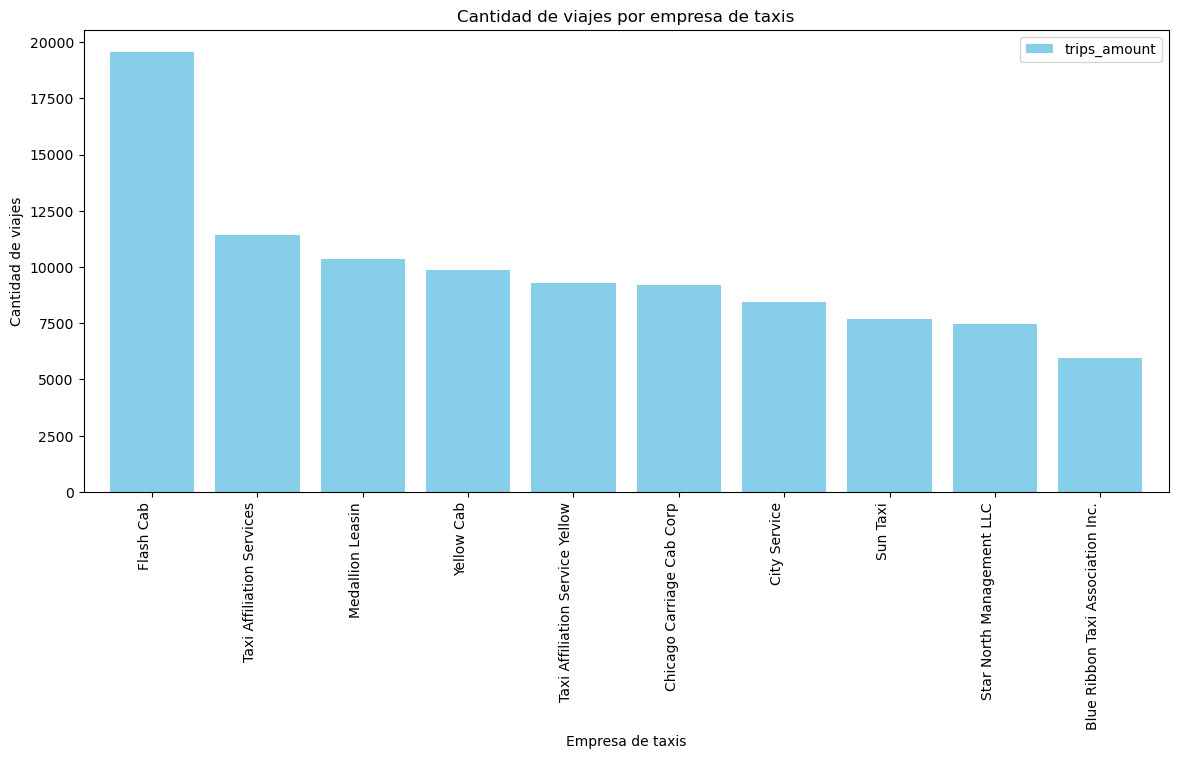

In [14]:
# Crear un gráfico de barras
indices_top_10 = df_companies['trips_amount'].nlargest(10).index
top_10_registros = df_companies.loc[indices_top_10]

ax = top_10_registros.plot(kind='bar', x='company_name', y='trips_amount', color='skyblue', figsize=(14, 6), width=0.8)

# Configurar el título y los ejes
plt.title('Cantidad de viajes por empresa de taxis')
plt.xlabel('Empresa de taxis')
plt.ylabel('Cantidad de viajes')

# Rotar los labels del eje x en 45 grados
ax.set_xticklabels(top_10_registros['company_name'], rotation=90, ha='right')

# Mostrar el gráfico
plt.show()

los 10 barrios principales por número de finalizaciones

Como se puede apreciar en la grafica, la cantidad de viajes de la compañia 'Flash Cab', esta casi el doble de cantidad de viajes que la compañia mas proxima, con una aproximacion de 20,000 viajes, siendo tansolo la información de 2 dias, 15 y 16 de noviembre, es claro la acepacion de la compañia por parte de los usuarios. Es materia de estudio, identificar los factores que generen estos resultados, para asi poder realizar las acciones prudentes para que otra compañia pueda ganarle mercado a la compañia 'Flash Cab' o en su defecto, para la compañia 'Flash Cab' el mejorar esos factores que le dan fortaleza a la compañia ademas de identifiar fortalezas de otras compañias para realizar una campaña para competir contra las demas  compañias y obtener mas presencia en el mercado.

#### Lista de todos los barrios

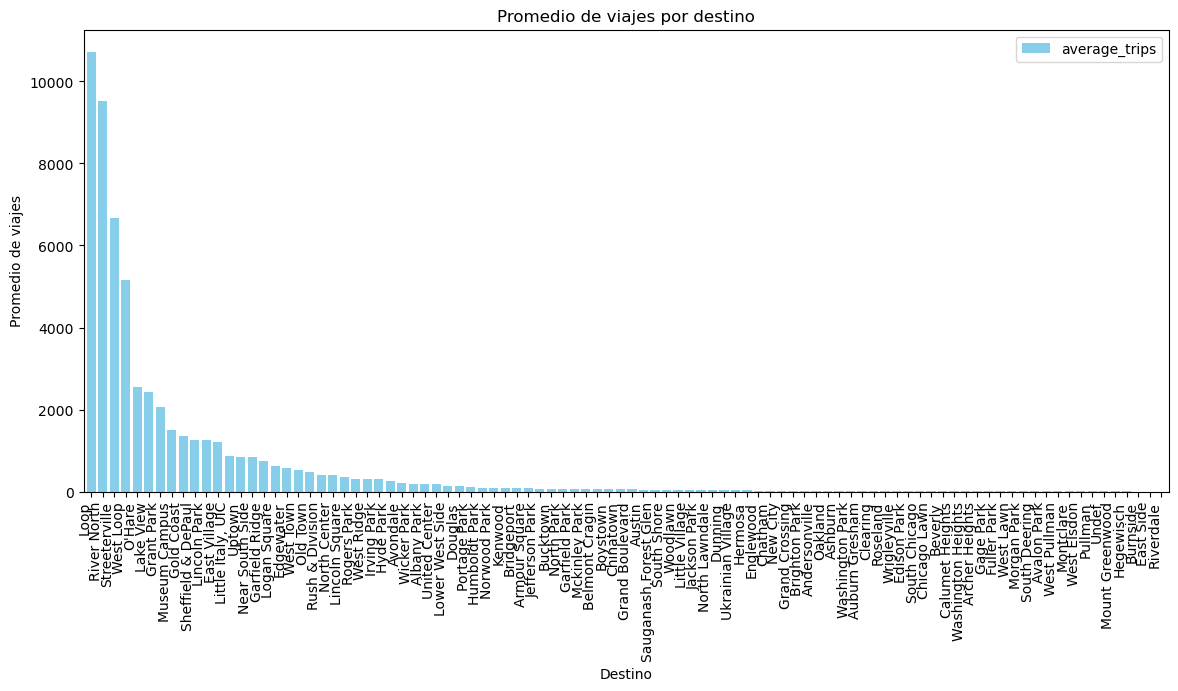

In [15]:

# Crear un gráfico de barras
ax = df_locations.plot(kind='bar', x='dropoff_location_name', y='average_trips', color='skyblue', figsize=(14, 6), width=0.8)

# Configurar el título y los ejes
plt.title('Promedio de viajes por destino')
plt.xlabel('Destino')
plt.ylabel('Promedio de viajes')

# Rotar los labels del eje x en 45 grados
ax.set_xticklabels(df_locations['dropoff_location_name'], rotation=90, ha='right')

# Mostrar el gráfico
plt.show()

#### lista del top 10 de los barrios

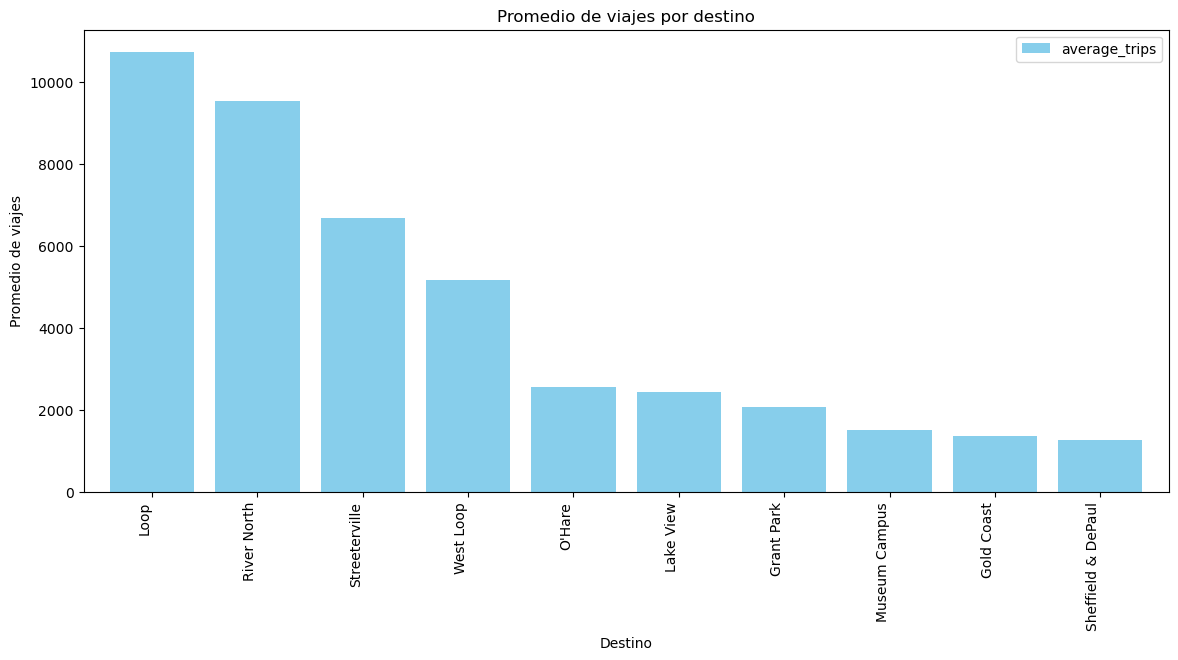

In [16]:
# Crear un gráfico de barras

indices_top_10 = df_locations['average_trips'].nlargest(10).index
top_10_registros = df_locations.loc[indices_top_10]

# Crear un gráfico de barras
ax = top_10_registros.plot(kind='bar', x='dropoff_location_name', y='average_trips', color='skyblue', figsize=(14, 6), width=0.8)

# Configurar el título y los ejes
plt.title('Promedio de viajes por destino')
plt.xlabel('Destino')
plt.ylabel('Promedio de viajes')

# Rotar los labels del eje x en 45 grados
ax.set_xticklabels(top_10_registros['dropoff_location_name'], rotation=90, ha='right')

# Mostrar el gráfico
plt.show()

En la anterior gráfica se oberva, cuales son los destinos mas concurridos, dende 'loop' y 'River North' son barrios geograficamente vecino y ambos son los mas concurridos en los destinos de los viajes.

# Paso 6. hipotesis <a id='hipotesis'></a>


<ul>
    <li><code>mostrar_info_dataframe_tabla(df_viajes)</code></li>
    <li><code>df_viajes.sample(5)</code></li>
    <li><code>df_viajes = df_viajes.drop_duplicates()</code></li>
    <li><code>mostrar_info_dataframe_tabla(df_viajes)</code></li>
</ul>

#El contenido se movio a la seccián de [Corrección de datos](#correcion-dato)





<ul>
    <li><code>#_La columna start_ts no es del tipo fecha._</code></li>
    <li><code>#df_viajes['start_ts'] = dates = pd.to_datetime(df_viajes['start_ts'])</code></li>
    <li><code>#mostrar_info_dataframe_tabla(df_viajes)</code></li>
</ul>

#El contenido se movio a la seccián de [Corrección de datos](#correcion-dato)

Prueba la hipótesis:

# Prueba las hipótesis

->hiportesis nula
H0 = "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare No cambia los sábados lluviosos"

->hipoetsis alternativa
H1 = "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos"

In [17]:

#hiportesis nula
H0 = "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare No cambia los sábados lluviosos"

#hipoetsis alternativa
H1 = "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos"

sabados_lluviosos = df_viajes[(df_viajes['start_ts'].dt.dayofweek == 5) & (df_viajes['weather_conditions'] == 'Bad')]['duration_seconds'].reset_index(drop=True)
population_mean = np.mean(df_viajes['duration_seconds'])


In [18]:
#prueba levene
try:
  # Calcula la prueba de Levene
  estadistico_levene, valor_p = levene(sabados_lluviosos, df_viajes['duration_seconds'])
  # Imprime el resultado
  print("Estadístico de Levene:", estadistico_levene)
  print("Valor p:", valor_p)
  # Comprueba el valor p para determinar si hay diferencias significativas en las varianzas
  nivel_significancia = 0.05
  if valor_p < nivel_significancia:
      print("Hay diferencias significativas en las varianzas entre los grupos.")
  else:
      print("No hay diferencias significativas en las varianzas entre los grupos.")
except Exception as error:
  print("¡Error! Ocurrió una excepción:", error)


Estadístico de Levene: 0.3172077482464419
Valor p: 0.5734146842198008
No hay diferencias significativas en las varianzas entre los grupos.


In [19]:

#ttest_ind()

#Determinar el valor de alpha
alpha = 0.05

try:
  #se utiliza ttest_1samp para determinar si la media de una muestra es 
  #estadísticamente significativamente diferente de una media poblacional conocida.
  results = st.ttest_1samp(sabados_lluviosos,population_mean, equal_var=False)
except:
  results = st.ttest_1samp(sabados_lluviosos,population_mean)

print('valor p:',results.pvalue)

#verificamos con la condicion el valor de p contra el valor de alpha 
if (results.pvalue < alpha):
    print()
    print("Rechazamos la hipótesis nula:")
    print(H0)
else:
    print()
    print("No podemos rechazar la hipótesis nula:")
    print(H1)

valor p: 1.2044589417991503e-06

Rechazamos la hipótesis nula:
La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare No cambia los sábados lluviosos


Quiere decir que el promedio de duración de los viajes de los sabados lluviosos, desde el Loop hasta el aeropuerto Internacional O'Hare no cambia el sabado por razones climatologicas; pero tampoco podemos descartarla del todo.



<div class="alert alert-block alert-info">
<b>Se Realizaron las siguientes actividades:</b>
    <ul>
        <li>Se importaron todas las librerías necesarias para el análisis correspondiente.</li>
        <li>Se definieron funciones que serían utilizadas para el análisis de los DataFrames.</li>
        <li>Se importaron los archivos 'project_sql_result_01.csv', 'project_sql_result_04.csv' y 'project_sql_result_07.csv' en DataFrames individuales.</li>
        <li>En una primera instancia se analizan las tablas en búsqueda de la cantidad de registros, valores nulos, valores duplicados, dispersión de los datos, valores máximos, valores mínimos, los cuartiles, se observa una muestra de los datos, se observan el tipo de datos de las columnas.</li>
        <li>Se realizaron las correcciones pertinentes, como por ejemplo, la duplicidad de datos, datos erráticos y conversión de tipo de datos (string a fecha).</li>
        <li>Se obtuvo el top 10 de las empresas de taxis, en relación al número de viajes.</li>
        <li>Se obtuvo el top 10 de los barrios 'destino' en los viajes.</li>
        <li>Se realizó una hipótesis sobre si existía un cambio significante en los viajes, si el día de la semana era sábado y ese día había lluvia.
            <ul>
                <li>Se realizó una prueba Levene para determinar si existían varianzas iguales, donde se llegó a la conclusión de que los viajes de Loop hasta el aeropuerto Internacional O'Hare no cambian el sábado por razones climatológicas.</li>
            </ul>
        </li>
    </ul>

</div>